## Concept shift experiments (V2)

In this version 2 of the concept shift experiments, we ensure that P(X) does not change in the experiments. In order to do this, P(y) changes with the cut point change. This way, the prevalence is not forced but computed naturally with the concept shift change. In the first version of these experiments, as we were forcing P(y) values, P(X) was chaning across experiments.

In [2]:
import pandas as pd
import seaborn as sns
from IPython.display import display
import matplotlib.pyplot as plt
import os

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 150)

#Font size for the plots
plt.rcParams['font.size'] = '16'


export_dir = '/home/pgonzalez/Dropbox/quant_datasetshift/'
quantificators = ["CC", "ACC", "PCC", "PACC", "DyS", "SLD"]
error = "MAE"
dateexperiment = "2022_09_26_13_26"


results_dict={}
print("Loading results... ",sep="")
for quant_name in quantificators:
    results_dict[quant_name] = pd.read_csv("results/concept/results_v2_%s_%s.csv" % (dateexperiment,quant_name),index_col=0)
    results_dict[quant_name]['MAE'] = results_dict[quant_name]['error'].abs()
    results_dict[quant_name]['cut_points'] = results_dict[quant_name]['cut_point_train']-results_dict[quant_name]['cut_point_test']
print("Done")

Loading results... 
Done


### Tables and charts to be included in a paper

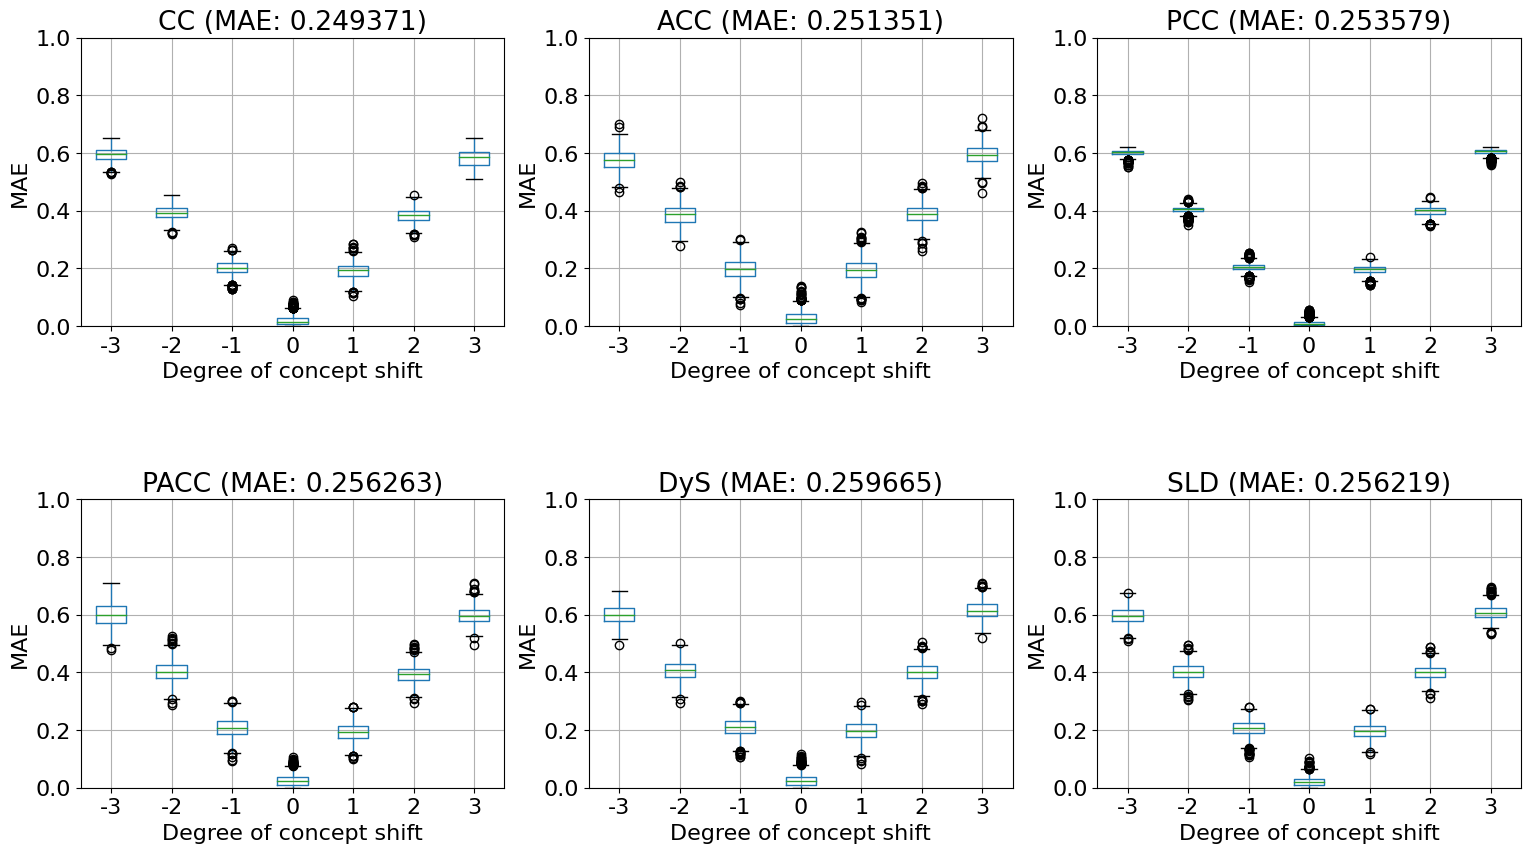

In [28]:
quantificators = ["CC", "ACC", "PCC", "PACC", "DyS", "SLD"]
fig, ax = plt.subplots(2,3,figsize=(18,10))
fig.subplots_adjust(wspace=0.8,hspace=0.6)

for k,quant_name in enumerate(quantificators):
    results = results_dict[quant_name]
    ax[k//3][k%3].set_ylim(0, 1)
    ax[k//3][k%3].set_ylabel(error)
    results.boxplot(ax=ax[k//3][k%3],column='MAE',by='cut_points')
    plt.suptitle('')
    ax[k//3][k%3].set_xlabel("Degree of concept shift")
    ax[k//3][k%3].set_title("%s (%s: %f)"  % (quant_name,'MAE',results['MAE'].mean()))
plt.savefig(os.path.join(export_dir,"images/conceptresults_v2.pdf"),format='pdf',bbox_inches='tight')
plt.savefig(os.path.join(export_dir, "images/conceptresults_v2.png"),format='png',bbox_inches='tight')


## Main tables for concept shift in the paper (version with AE)

This table has the results for concept shift. It is meant to be in the main paper.

In [3]:
from utils.wilcoxon import wilcoxon_test
import numpy as np
quantificators = ["CC", "ACC", "PCC", "PACC", "DyS", "SLD"]
global_results = pd.DataFrame(columns = ["p(y) change"]+quantificators,index=np.arange(-3,4),dtype=float)
for k,quant_name in enumerate(quantificators):
    results = results_dict[quant_name]
    results = results.groupby(by='cut_points')['MAE'].mean()
    global_results['p(y) change'] = global_results.index*0.2
    global_results.loc[:, quant_name] = results

global_results_style = global_results.style.format({**{"p(y) change": '{:.1f}'},**dict.fromkeys(quantificators,'{:.3f}')})

#We want to make a statistical test for each row, to compare methods for the same degree of covariate shift
for i,r in global_results.iterrows():
    r = r.drop('p(y) change')
    #compute the best method for this experiment
    cut_points = r.name
    best_method = r.index[r.argmin()]
    #print("Computing statistical test for experiment covariate degree=%f, p_test=%s. Winner method %s" % (covariate_measure,p_test,best_method))
    #Get data for the winner method
    results_best = results_dict[best_method].loc[(results_dict[best_method]['cut_points']==cut_points),'MAE'].to_numpy()
    #We need to get all the rows in results that matches this experiment for each method
    for quant_name in quantificators:
        if quant_name!=best_method:
            #print("Comparing %s with %s" % (best_method,quant_name))
            results_method = results_dict[quant_name].loc[results_dict[quant_name]['cut_points']==cut_points,'MAE'].to_numpy()
            global_results_style.set_properties(subset=(cut_points, quant_name),**wilcoxon_test(results_best,results_method))


result = global_results_style.highlight_min(axis=1,props='textbf:--rwrap;',subset=quantificators)
display(result)
columns = 'r'*(len(quantificators)+1)
with open(os.path.join(export_dir,'tables/conceptv2_table.tex'), 'w') as f:
    f.write(result.to_latex(hrules=True,column_format="r|"+columns).replace(' 0.',' .').replace('{0.','{.'))


,p(y) change,CC,ACC,PCC,PACC,DyS,SLD
-3,-0.6,0.592,0.579,0.601,0.599,0.601,0.597
-2,-0.4,0.393,0.386,0.404,0.403,0.406,0.401
-1,-0.2,0.202,0.198,0.206,0.208,0.210,0.206
0,0.0,0.021,0.030,0.012,0.026,0.027,0.022
1,0.2,0.191,0.195,0.195,0.193,0.197,0.197
2,0.4,0.383,0.389,0.398,0.394,0.400,0.399
3,0.6,0.583,0.594,0.603,0.599,0.615,0.608
